In [1]:
%matplotlib inline
import os
import cPickle as pkl
import numpy as np
import pandas as pd
import colorsys
import matplotlib.colors as mc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.patheffects as path_effects
import seaborn as sns
import common.metrics as met
import common.plots as plo
import logging
import lasagne_nn.log_parser as lp
import json
from itertools import izip
from common.plot_fcns import *

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# data handling

def get_preds(dset_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if dset_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
        
    return prediction, truth

In [3]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Credit: Ian Hincks from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    try:
        c = mc.cnames[color]
    except:
        c = color

    c = colorsys.rgb_to_hls(*mc.colorConverter.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [4]:
classification_data_file = "./classification_preds_file_lookup.pkl"
with open(classification_data_file, "rb") as f:
    data_dict = pkl.load(f)
with open("../regression/color_dict_pt.pkl", "rb") as f: 
    color_dict_pt = pkl.load(f)
with open("../regression/color_dict_bar.pkl", "rb") as f: 
    color_dict_bar = pkl.load(f)

In [5]:
expts = data_dict.keys()
df = pd.DataFrame(columns=["expt", "dset", "fold", "ratio", "AUROC", "AUPRC"])
data_dict.keys()
ratio_val = "1.0"
thresh=5.0
classification=True
make_data = False

if make_data:
    for expt in expts:
        ratio_explicit = data_dict[expt]["ratios"]
        ratio = None if not ratio_explicit else ratio_val
        for dset in ["drugmatrix", "timesplit", "test", "train"]:
            for fold in np.arange(0,5,1):
                prediction, truth = get_preds(data_dict, expt, dset, fold, ratio=ratio)

                if dset != "drugmatrix":
                    known_mask = ~np.isnan(truth)
                    truth = truth[known_mask]
                    prediction = prediction[known_mask]
                prediction = prediction.ravel()
                truth = truth.ravel()
                auroc, _, _, _, _ = met.compute_binary_auc(prediction, truth, classification=classification,
                                                               threshold=thresh, x_y_type="tpr-fpr")
                auprc, _, _, _, _ = met.compute_binary_auc(prediction, truth, classification=classification,
                                                               threshold=thresh, x_y_type="precision-recall")

                if dset == "drugmatrix":
                    known_mask = ~np.isnan(truth)
                    truth = truth[known_mask]
                    prediction = prediction[known_mask]

                input_data={"expt":[expt],"dset" :[dset], "fold": [fold], "ratio":[ratio_val], "AUROC":[auroc], 
                            "AUPRC":[auprc]}
                df = pd.concat([df, pd.DataFrame(input_data)], sort=False)
    plot_data_save_base = "{}/20190410_SMA_Investigation/plot_data/classification".format(get_env_var("DATA_SAVE_BASE"))
    df.to_csv("{}/neighbors_plot_vals.tsv".format(plot_data_save_base), sep='\t')

In [6]:
plot_data_save_base = "{}/20190410_SMA_Investigation/plot_data/classification".format(get_env_var("DATA_SAVE_BASE"))
df = pd.read_csv("{}/neighbors_plot_vals.tsv".format(plot_data_save_base), sep="\t", index_col=0)

In [7]:
old_df = df.copy()
df = df.drop("ratio", axis=1)

In [9]:
def rename_vals(df):
    # rename expts
    df.expt[df.expt == 'CLASSIFIER_STD'] = "STD (classifier)"
    df.expt[df.expt == 'CLASSIFIER_NEG_RM'] = "Negatives Removed (classifier)"
    df.expt[df.expt == 'CLASSIFIER_NEG_RM_scrambled'] = "Negatives Removed scrambled (classifier)"
    df.expt[df.expt == 'CLASSIFIER_SEA_SMA'] = "SNA +SEA blacklist (classifier)"
    
    df.expt[df.expt == 'CLASSIFIER_scrambled_idx_LC'] = "SNA scrambled (classifier)"
    df.expt[df.expt == 'CLASSIFIER_scrambled_idx_No_SMA_LC'] = "STD scrambled (classifier)"
    df.expt[df.expt == 'CLASSIFIER_SMA_RATIOS'] = "SNA (classifier)"
    df.expt[df.expt == 'CLASSIFIER_NEG_RM_SMA_RATIOS'] = "Negatives Removed +SNA (classifier)"
    df.expt[df.expt == 'CLASSIFIER_NEG_RM_RATIOS_scrambled'] = "Negatives Removed +SNA scrambled (classifier)"
    # and dsets
    df.dset[df.dset == "drugmatrix"] = "Drug Matrix"
    df.dset[df.dset == "timesplit"] = "Time Split"
    df.dset[df.dset == "test"] = "Test"
    df.dset[df.dset == "train"] = "Train" 
    return df

save_dir = "{}/final_paper_figs".format(get_env_var("HOME"))

In [10]:
expt_color_lookup = {
"NEG_RM": "NEG_RM",
"STD": "STD",
"NEG_RM_SMA": "NEG_RM_SMA",
'NEG_RM_RATIOS': "NEG_RM_SMA",
"STD_SMA": "STD_SMA",
"scrambled_idx": "scrambled_idx",
"scrambled_idx_LC": "scrambled_idx",
"SEA_SMA": "SEA_SMA",
"scrambled_idx_no_SMA": "scrambled_idx_no_SMA",
"scrambled_idx_no_SMA_LC": "scrambled_idx_no_SMA",
"CLASSIFIER_SEA_SMA": "SEA_SMA",
"CLASSIFIER_NEG_RM_SMA_RATIOS":  "NEG_RM_SMA",
"CLASSIFIER_SMA_RATIOS": "STD_SMA",
"CLASSIFIER_scrambled_idx_LC": "scrambled_idx",
"CLASSIFIER_scrambled_idx_No_SMA_LC": "scrambled_idx_no_SMA",
"CLASSIFIER_STD": "STD", 
"NEG_RM_scrambled": "NEG_UW", 
"NEG_RM_RATIOS_scrambled": "SEA_SMA",
'CLASSIFIER_NEG_RM_scrambled' : "NEG_UW",
'CLASSIFIER_NEG_RM_RATIOS_scrambled': "SEA_SMA",
'CLASSIFIER_NEG_RM': 'NEG_RM',
'NEG_UW': 'NEG_UW',
'CLASSIFIER_SEA_SMA_LR03': 'SEA_SMA'}

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

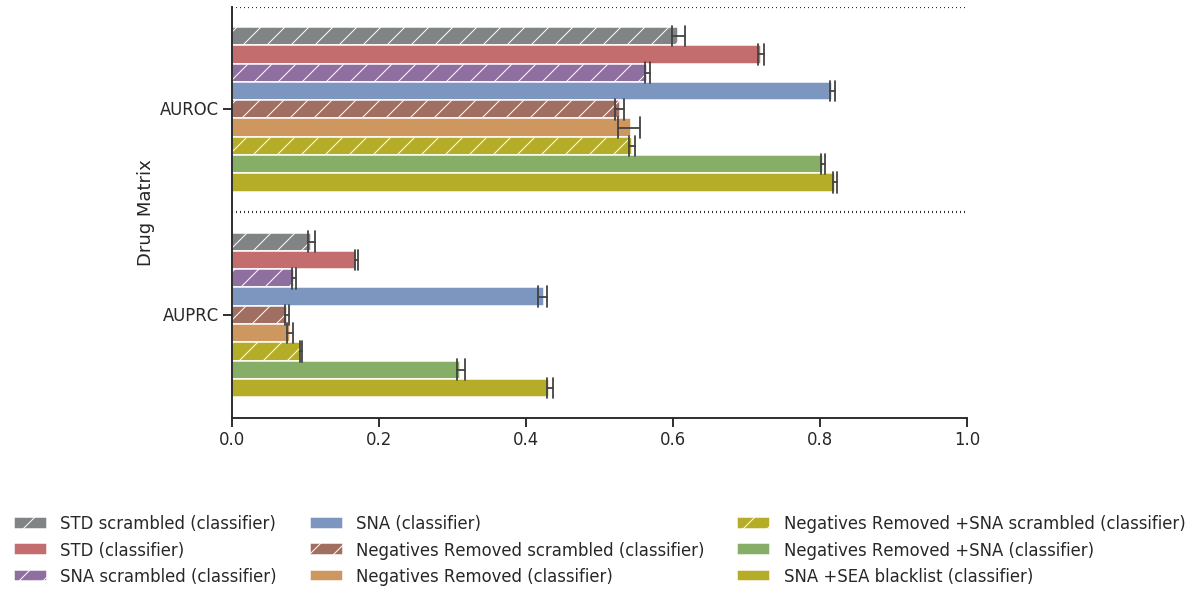

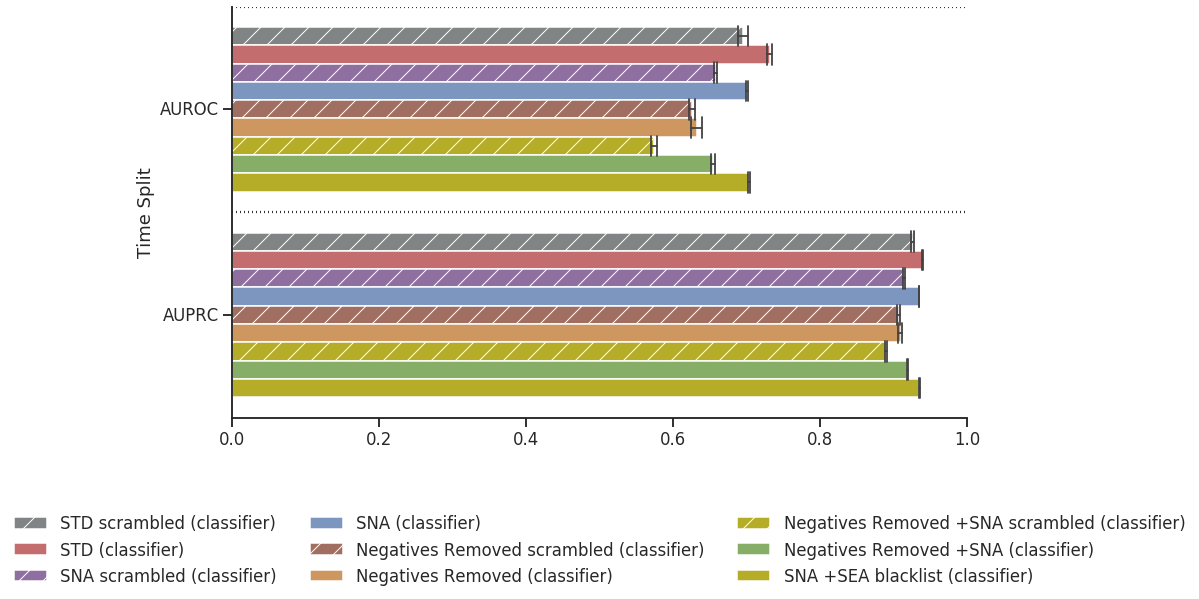

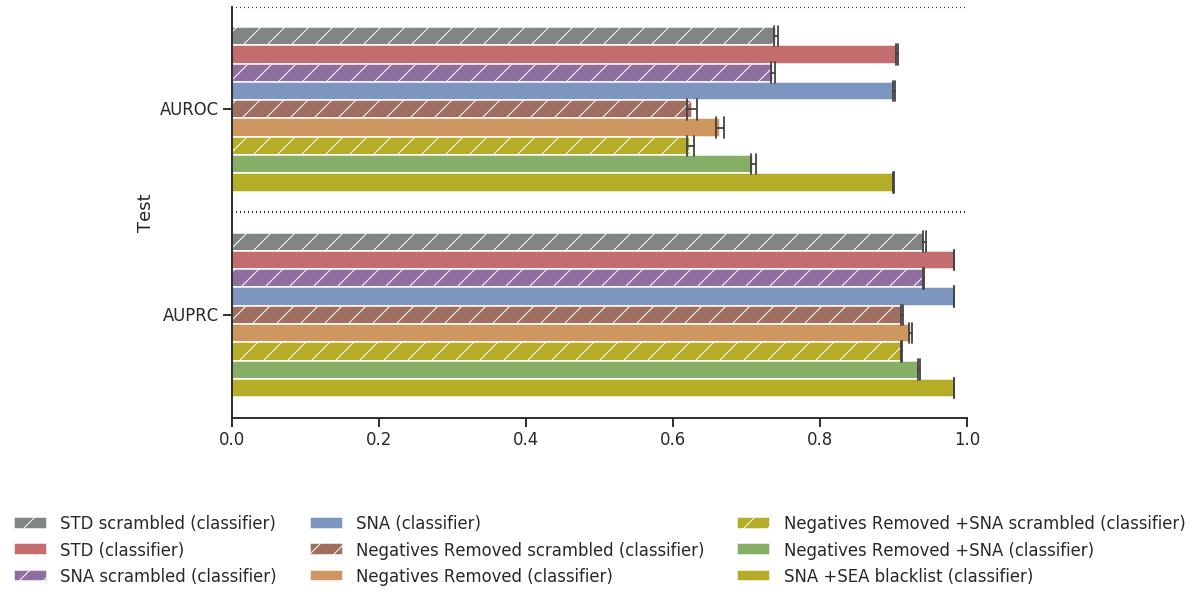

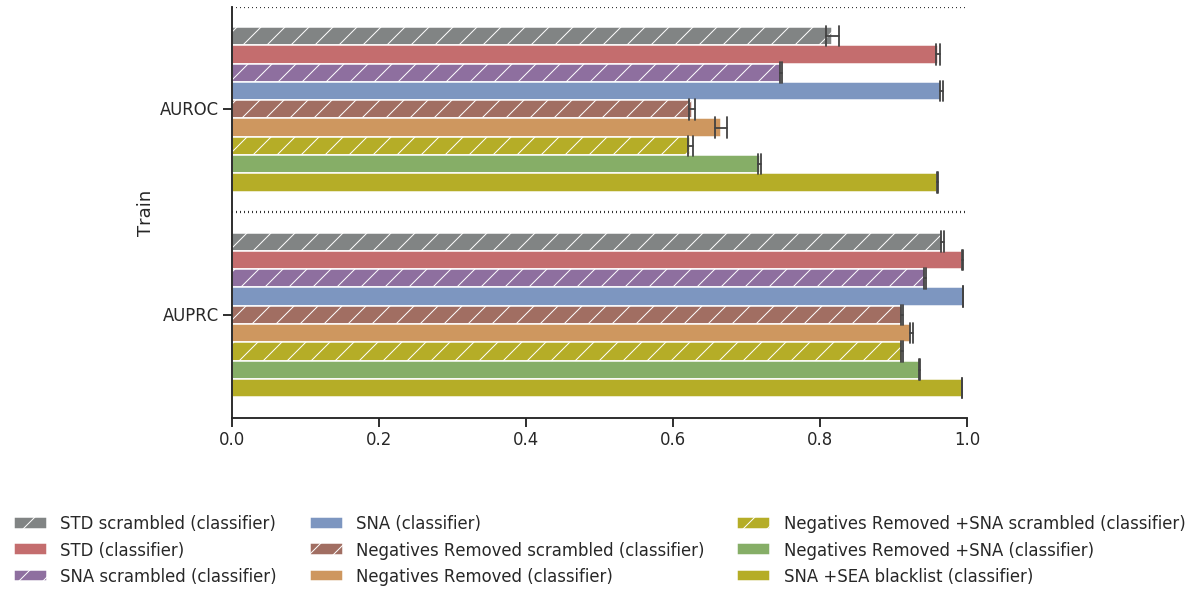

In [11]:
sns.set(style="white")
sns.set_context("talk")
amt = 1.5


expts_colors = ['CLASSIFIER_scrambled_idx_No_SMA_LC',  'CLASSIFIER_STD', 
        'CLASSIFIER_scrambled_idx_LC','CLASSIFIER_SMA_RATIOS',
        'CLASSIFIER_NEG_RM_scrambled', "CLASSIFIER_NEG_RM",
        "CLASSIFIER_NEG_RM_RATIOS_scrambled", 'CLASSIFIER_NEG_RM_SMA_RATIOS',
        'CLASSIFIER_SEA_SMA'
       ]


expts = ["STD scrambled (classifier)",  "STD (classifier)",
        "SNA scrambled (classifier)","SNA (classifier)",
        "Negatives Removed scrambled (classifier)", "Negatives Removed (classifier)",
        "Negatives Removed +SNA scrambled (classifier)", "Negatives Removed +SNA (classifier)",
        "SNA +SEA blacklist (classifier)"
       ]

new_palette = []
legend=False

for dset in df.dset.unique():
#     if dset == "train": 
#         legend = True
#     else:
#         legend = False
    for i in expts_colors:
        if "CLASSIFIER" in i:
            new_palette.append(color_dict_bar[expt_color_lookup[i]])

    legend = True
    tmp_df = df[df["dset"] == dset]
    tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
    tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
    tmp_df=rename_vals(tmp_df)

    g = sns.catplot(y="metric", x="value", hue="expt", hue_order=expts, data=tmp_df, kind="bar", 
                    palette=new_palette, orient="h", legend=False, legend_out=True, height = 7, aspect=1.75,
                    **{"capsize":0.1, "errwidth":1.8})
    
    (g.despine(right=True)
    .set_ylabels(tmp_df.dset.unique().tolist()[0])
    .set_xlabels("")
    .ax.tick_params(top=False, right=False)
    )

    g.ax.set_xlim((0,1))
    line_offset=0

    lower, upper = g.ax.get_ybound()
    
    for i in np.arange(lower, upper, 1):
        g.ax.axhline(i, ls=":", c=".2")
    
    hatch = [  "/", "/", "", "",]*(len(expts)-5)
    hatch.extend(["", ""])
    leg_artists = []

    for i,thisbar in enumerate(g.ax.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatch[i])

    legend=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
    plt.show()
#     plt.savefig("{}/{}_all_class_bar_plots_and_ctrls.png".format(save_dir, dset), dpi=300, 
#                 bbox_extra_artists=[legend,], bbox_inches="tight")
    plt.clf()
#     plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

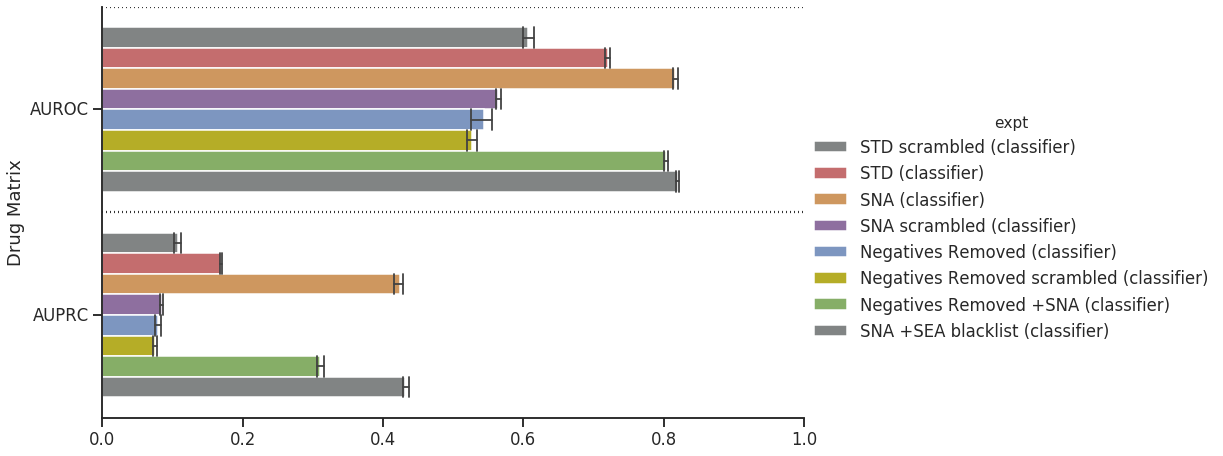

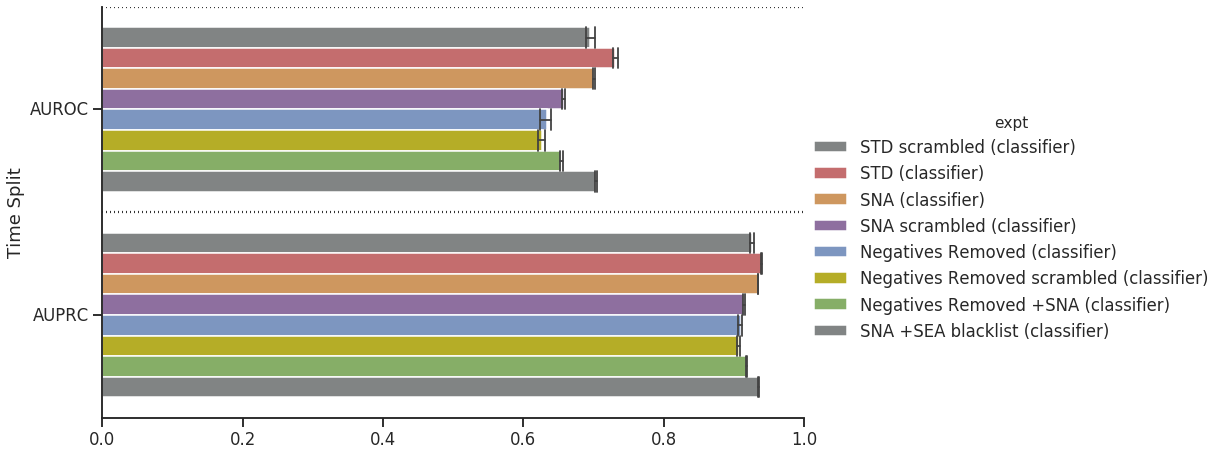

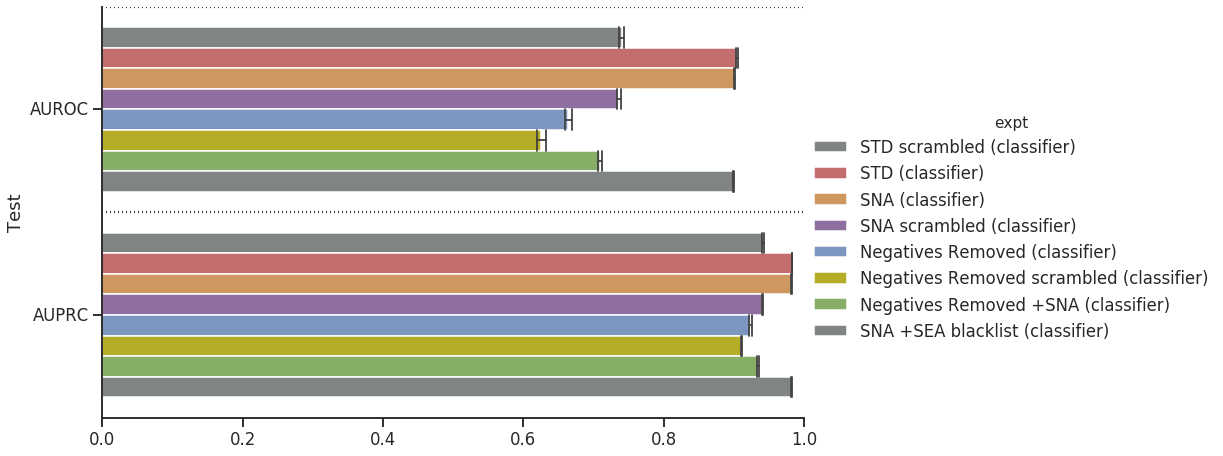

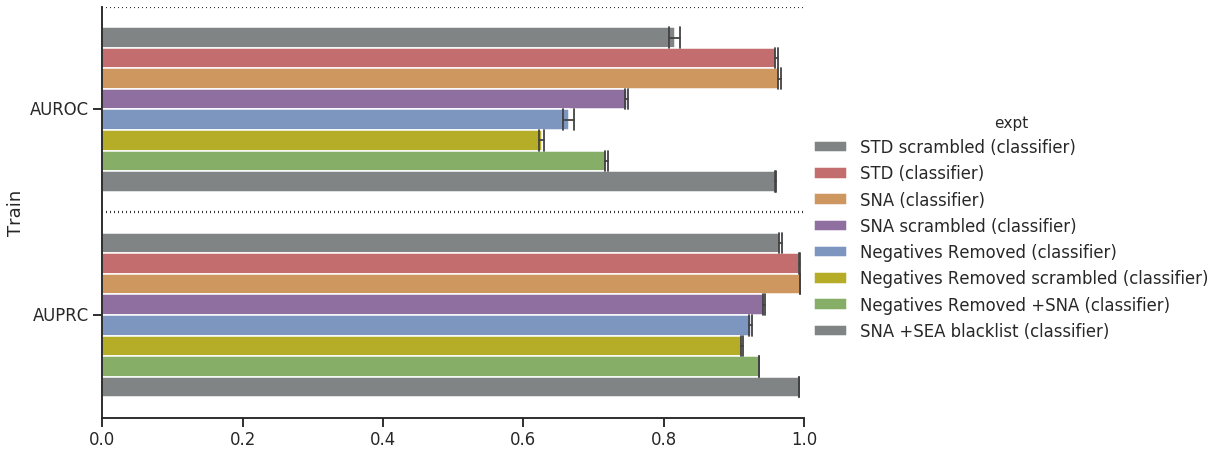

In [39]:
sns.set(style="white")
sns.set_context("talk")
amt = 1.5

expts = ['scrambled_idx_no_SMA', 'STD', 'NEG_RM', 'scrambled_idx', 'STD_SMA', "SEA_SMA", 'NEG_RM_SMA']
new_palette = [color_dict_bar[i] for i in expts]

expts= [ 'CLASSIFIER_scrambled_idx_No_SMA_LC',  'CLASSIFIER_STD', "CLASSIFIER_NEG_RM",
        'CLASSIFIER_scrambled_idx_LC','CLASSIFIER_SMA_RATIOS','CLASSIFIER_SEA_SMA','CLASSIFIER_NEG_RM_SMA_RATIOS', 'CLASSIFIER_NEG_RM_RATIOS_scrambled',
     'CLASSIFIER_SEA_SMA']


expts = ['STD scrambled (classifier)', 'STD (classifier)',
         'SNA (classifier)', 'SNA scrambled (classifier)',
         'Negatives Removed (classifier)', 'Negatives Removed scrambled (classifier)',
         'Negatives Removed +SNA (classifier)',
         'SNA +SEA blacklist (classifier)', 
       ]
# expts= [ 'STD scrambled (classifier)',  'STD (classifier)', 'NEG_RM (classifier)',
#          'SMA scrambled (classifier)', 'SMA (classifier)', 'SEA SMA (classifier)',
#         'NEG_RM SMA (classifier)']

for dset in df.dset.unique():
    legend = True
    tmp_df = df[df["dset"] == dset]
    tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
    tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
    tmp_df = rename_vals(tmp_df.copy())
    dset = tmp_df.dset.unique().tolist()[0]
    g = sns.catplot(y="metric", x="value", hue="expt", hue_order=expts, data=tmp_df, kind="bar", 
                    palette=new_palette, orient="h", legend=legend, legend_out=True, height = 7, aspect=1.75,
                    **{"capsize":0.1, "errwidth":1.8})
    
    (g.despine(right=True)
    .set_ylabels(dset)
    .set_xlabels("")
    .ax.tick_params(top=False, right=False)
    )

    g.ax.set_xlim((0,1))
    line_offset=0

    lower, upper = g.ax.get_ybound()
    
    for i in np.arange(lower, upper, 1):
        g.ax.axhline(i, ls=":", c=".2")
        
#     handles, labels = g.ax.get_legend_handles_labels()
#     pylab.legend(loc=0,)